<h1><center>Kaggle Competition: [Recruit Restaurant Visitor Forecasting](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting)</center></h1> 

---
**Summary**

[**1. Load, Merge and Clean the Dataset**](#1.-Load,-Merge-and-Clean-the-Dataset)

[**2. Feature Engineering**](#2.-Feature-Engineering)

[**3. Evaluate the Regression Model**](#3.-Regression-Model-Evaluation)

[**4. Kaggle Submission**](#4.-Kaggle-Submission)

---

# 1. Load, Merge and Clean the Dataset

In [1]:
# load all datasets, then merge and clean them to be used:
import pandas as pd
from lib import clean_db

full_df = clean_db.load_from('data')                      # 'data': directory that contains .csv files
full_df.visit_date = pd.to_datetime(full_df.visit_date)   # Convert column visit_date to Datetime object
    
def get_full_dataframe():
    return full_df

A Jupyter Widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

# 2. Feature Engineering

In [3]:
# build_features(): receives the full dataset and does some feature engineering to add relevant features.
def build_features(full_df):        
    # convert 'visit_date' into numeric variables
    df = full_df[ ['air_store_id', 'visit_date', 'visitors', 'day_of_week', 'holiday_flg', 'reservations', 'latitude', 'longitude'] ].copy()
    df['year'] = full_df['visit_date'].dt.year
    df['month'] = full_df['visit_date'].dt.month
    df['day'] = full_df['visit_date'].dt.day

    ### 
    # New feature: convert 'day_of_week' categorical feature into dummy variable
    ###
    df = pd.get_dummies(df, columns=['day_of_week'])
        
    ### 
    # New feature: compute daily visitors statistics per day of the week
    ###
    df.visit_date = pd.to_datetime(df.visit_date)
    df['dow'] = df['visit_date'].apply(lambda x: x.weekday())  # Monday=0, Sunday=6

    # Calculate mean() median() and size() for every restaurant per day of the week
    tmp = df.groupby(['air_store_id','dow']).agg({'visitors' : [np.mean,np.median,np.size]}).reset_index()
    tmp.columns = ['air_store_id', 'dow', 'mean_visitors', 'median_visitors','count_observations']
    df = pd.merge(df, tmp, how='left', on=['air_store_id','dow']) 
    
    ### 
    # New feature: store the geografical distance between the restaurant and the most distant restaurant
    ###
    df['max_lat_dist'] = df['latitude'].max() - df['latitude']
    df['max_long_dist'] = df['longitude'].max() - df['longitude']
    
    ### New feature: compute daily reservations statistics per day of the week
    tmp = df.groupby(['air_store_id','dow']).agg({'reservations' : [np.mean,np.size]}).reset_index()
    tmp.columns = ['air_store_id', 'dow', 'mean_reservations', 'count_reservations']    
    df = pd.merge(df, tmp, how='left', on=['air_store_id','dow']) 
        
    return df

In [13]:
# get_features(): returns a list of all column names used as features, except a few ones.
def get_feature_names(df):
    feature_names = df.columns.values.tolist()
    feature_names.remove('visitors')
    feature_names.remove('visit_date')
    feature_names.remove('air_store_id')
    return feature_names

# 3. Regression Model Evaluation

In [5]:
# plot_correlation(): plots the correlation between different features.
def plot_correlation(df):    
    plt.figure(figsize=(8, 8))
    sns.heatmap(df.corr(), square=True, cmap='YlOrRd')  # RdBu_r, YlOrRd
    plt.plot()
    plt.show()    

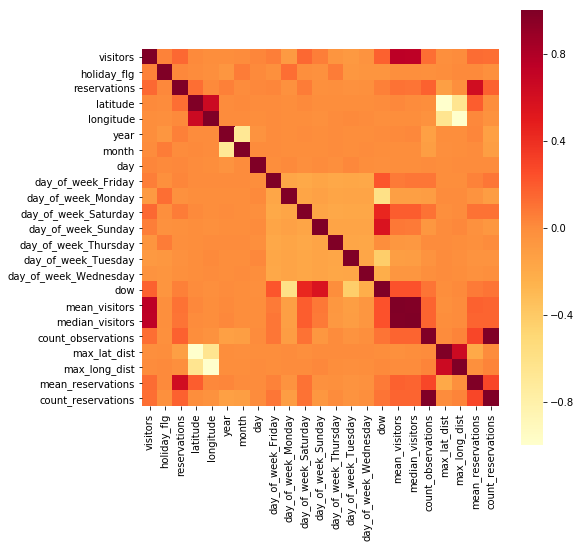

In [6]:
full_df = get_full_dataframe()
df = build_features(full_df)
plot_correlation(df)

In [7]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from itertools import compress

# evaluate_feature_association(): evaluate features based on the level of association with its target
def evaluate_feature_association(df):
    feature_names = get_feature_names(df)
    X = df[feature_names]
    y = df.visitors

    selector_f = SelectPercentile(f_regression, percentile=25)
    selector_f.fit(X,y)

    zipped_list = zip(feature_names, selector_f.scores_)
    zipped_list = sorted(zipped_list, key=lambda x: x[1])

    # Print most important features first:
    for feature, score in reversed(zipped_list):
        print('>>> F-score: %3.2f \t%s ' % (score, feature))
        

# evaluate_feature_contribution(): choose features based on their effective contribution.
# Automatically reduce the number of features involved in a learning model on the basis of their effective 
# contribution to the performance measured by the error measure.
def evaluate_feature_contribution(df):
    feature_names = get_feature_names(df)
    X = df[feature_names]
    y = df.visitors
    
    reg = LinearRegression(normalize=True) 
    selector = RFECV(estimator=reg, cv=5, scoring='neg_mean_squared_error')
    selector.fit(X, y)

    print('\n>>> Features ( size=', len(feature_names), ')\n', feature_names)
    print('\n>>> Optimal Features ( size=', selector.n_features_, ')\n', list(compress(feature_names, selector.support_)))

In [8]:
evaluate_feature_association(df)
evaluate_feature_contribution(df)

>>> F-score: 326633.33 	mean_visitors 
>>> F-score: 308867.25 	median_visitors 
>>> F-score: 8535.30 	dow 
>>> F-score: 5564.14 	reservations 
>>> F-score: 5320.88 	day_of_week_Saturday 
>>> F-score: 4425.61 	mean_reservations 
>>> F-score: 3754.15 	count_reservations 
>>> F-score: 3754.15 	count_observations 
>>> F-score: 2008.97 	day_of_week_Monday 
>>> F-score: 1778.92 	day_of_week_Tuesday 
>>> F-score: 938.31 	day_of_week_Sunday 
>>> F-score: 839.61 	day_of_week_Friday 
>>> F-score: 703.73 	day_of_week_Thursday 
>>> F-score: 526.54 	day_of_week_Wednesday 
>>> F-score: 443.92 	holiday_flg 
>>> F-score: 187.03 	day 
>>> F-score: 43.63 	max_lat_dist 
>>> F-score: 43.63 	latitude 
>>> F-score: 8.17 	max_long_dist 
>>> F-score: 8.17 	longitude 
>>> F-score: 2.47 	month 
>>> F-score: 0.32 	year 

>>> Features ( size= 22 )
 ['holiday_flg', 'reservations', 'latitude', 'longitude', 'year', 'month', 'day', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunda

In [22]:
### Setup plots to compare visitation data
def plot_actual_vs_predicted(y, y_test, y_pred):
    plt.figure(figsize=(17,7))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, s=15, alpha=0.3, color='blue') 
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=1)
    plt.title('Actual Visitation data vs Predicted Visitation')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, s=10, alpha=0.3, color='blue') 
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-', lw=1)
    plt.title('Actual Visitation data vs Predicted Visitation (zoomed)')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.xlim(xmin=0, xmax=120)
    plt.ylim(ymin=0, ymax=120)

    plt.show()

>>>   RMSLE Score: 21.9915554651
>>> CV Mean Score: 0.566590891348 	CV Tests: [ 0.55119129  0.54797364  0.58006312  0.58046452  0.57326187]


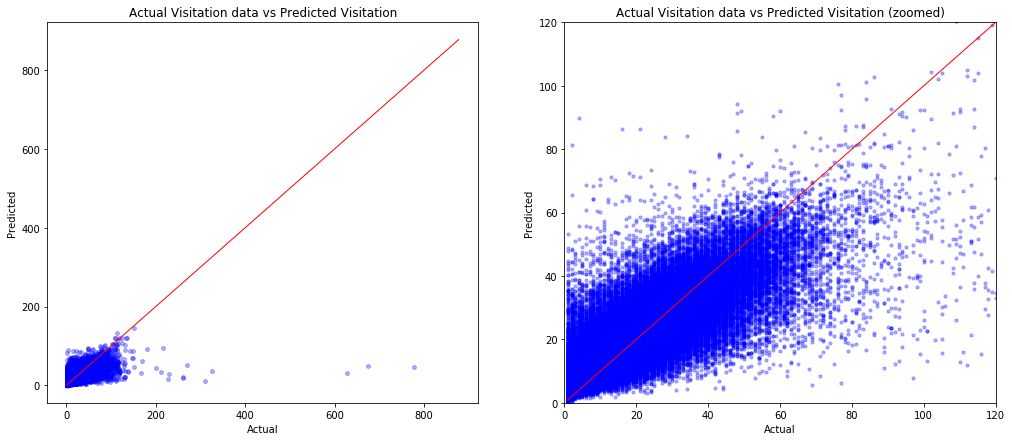

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Load dataset and engineer some features
full_df = get_full_dataframe()
df = build_features(full_df)

# Create (X,y): the multidimensional array of features and the array with the target value (visitors)
feature_names = get_feature_names(df)
X = df[feature_names]
y = df.visitors

# Split X,y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Execute a Regression model and measure it's score!
# Even thought np.log1p() and np.expm1() improve RMSLE from 22.0 to 32.3, Kaggle Score is unnafected by this change.
model = LinearRegression(normalize=True, n_jobs=4) 
model.fit(X_train, y_train)
# model.fit(X_train, np.log1p(y_train))

y_pred = model.predict(X_test)
# y_pred = np.expm1(y_pred)

print('>>>   RMSLE Score:', metrics.mean_squared_error(np.log1p(y_test), y_pred) ** 0.5)

cv_results = cross_val_score(model, X, y, cv=5)                                  # 22.0091612801
print('>>> CV Mean Score:', np.mean(cv_results), '\tCV Tests:', cv_results)      #  0.56658259318

plot_actual_vs_predicted(y, y_test, y_pred)

# 4. Kaggle Submission

In [10]:
# load_submission_file(): reads sample_submissions.csv and returns a DataFrame with extra columns parsed from 'id'
def load_submission_file():
    sub_df = pd.read_csv('data/sample_submission.csv')    
    
    # parse store_id from: air_00a91d42b08b08d9_2017-04-23
    sub_df['air_store_id'] = sub_df.id.map(lambda x: '_'.join(x.split('_')[:-1]))  
    
    # parse date from: from: air_00a91d42b08b08d9_2017-04-23
    sub_df['visit_date'] = sub_df.id.map(lambda x: x.split('_')[2])
    
    # erase visitors column
    sub_df.drop('visitors', axis=1, inplace=True)    
    #sub_df.drop('id', axis=1, inplace=True) 
          
    return sub_df

In [11]:
def build_submission_features(sub_df, short_df):        
    # To fill the column 'holiday_flg', pretend submission's visit_date is from the previous year and copy those holidays
    sub_df['visit_date'] = sub_df['visit_date'].str.replace('2017','2016')
    sub_df.visit_date = pd.to_datetime(sub_df.visit_date)

    # Drop duplicates in holidays_df to avoid adding more rows to the merged Dataframe
    holidays_df = short_df[['visit_date', 'holiday_flg']]
    holidays_df = holidays_df.drop_duplicates(subset=['visit_date'])

    ### Add HOLIDAY_FLG: fill with holidays from 2016
    sub_df = pd.merge(sub_df, holidays_df[['visit_date', 'holiday_flg']], on='visit_date', how='left')

    # Convert 'visit_date' to string and revert back to the original year (2017)
    sub_df['visit_date'] = sub_df['visit_date'].dt.strftime('%Y-%m-%d')
    sub_df['visit_date'] = sub_df['visit_date'].str.replace('2016','2017')
    sub_df.visit_date = pd.to_datetime(sub_df.visit_date)

    # Add MAX_LAT_DIST, MAX_LONG_DIST, LATITUDE and LONGITUDE
    geo_df = short_df[['air_store_id', 'max_lat_dist', 'max_long_dist', 'latitude', 'longitude']].drop_duplicates()
    sub_df = pd.merge(sub_df, geo_df, how='left', on=['air_store_id']) 
    
    # Add 'DAY_OF_WEEK' column
    import calendar
    sub_df['day_of_week'] = sub_df['visit_date'].apply(lambda x: (calendar.day_name[x.weekday()]))
    sub_df = pd.get_dummies(sub_df, columns=['day_of_week'])

    # Add YEAR, MONTH, DAY columns
    sub_df['year'] = sub_df['visit_date'].dt.year
    sub_df['month'] = sub_df['visit_date'].dt.month
    sub_df['day'] = sub_df['visit_date'].dt.day
    
    # Add DOW (Day Of the Week)
    sub_df['dow'] = sub_df['visit_date'].apply(lambda x: x.weekday())  # Monday=0, Sunday=6
    
    # Add visitor-statistics    
    stats_df = short_df[['air_store_id','dow', 'mean_visitors', 'median_visitors', 'count_observations']]
    stats_df = stats_df.drop_duplicates()    
    sub_df = pd.merge(sub_df, stats_df, how='left', on=['air_store_id','dow'])          

    # At this point, some restaurants will have NaNs in visitor-statistics columns because 
    # there was no training data of that restaurant for that particular weekday (ex: Monday).
    # Check with: 
    #    display(short_df[(short_df.air_store_id == 'air_0164b9927d20bcc3') & (short_df.dow == 6)].head())
    # Print rows with NaN values: 
    #    missing_stats_df = sub_df[sub_df.isnull().any(axis=1)]
    #
    # But here is how we are going to handle it:
#     sub_df.fillna(0, inplace=True)           # Both alternatives don't change the score (0.546)
    sub_df = sub_df.fillna(sub_df.mean())
        
    # Add reservation
    sub_df['reservations'] = -1
    
    # Add reservation statistics
    stats_df = short_df[['air_store_id','dow', 'mean_reservations', 'count_reservations']]
    stats_df = stats_df.drop_duplicates()    
    sub_df = pd.merge(sub_df, stats_df, how='left', on=['air_store_id','dow'])  
    sub_df = sub_df.fillna(sub_df.mean())                  

    # Delete unecessary columns
    del sub_df['air_store_id']
    del sub_df['visit_date'] 
    
    return sub_df

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

### Load sample_submissions.csv into the DataFrame that's used for submission on Kaggle
sub_df = load_submission_file()
print('>>> sub_df (original) shape=', sub_df.shape)
# display(sub_df.head(2))

### Do some magic and create the necessary features for prediction
sub_df = build_submission_features(sub_df, df)
print('>>> sub_df (features) shape=', sub_df.shape)
# display(sub_df.head(2))

### Load the full dataset and engineer some features
full_df = get_full_dataframe()
df = build_features(full_df)

# Create (X,y): the multidimensional array of features and the array with the target value (visitors)
feature_names = get_feature_names(df)
X = df[feature_names]
y = df.visitors

### Alternative 1 - Kaggle: 0.723
### Fit a Linear regression model and use it to predict the amount of visitors for each restaurant
# model = LinearRegression(n_jobs=6)
# model = Lasso(alpha=0.0004)
# model = Ridge(alpha=11.2) #
gbr_model = GradientBoostingRegressor(n_estimators=200, random_state=7, learning_rate=0.1, max_depth=7) # with log, exp: 0.514
gbr_model.fit(X, np.log1p(y))

rfr_model = RandomForestRegressor(n_jobs=6, bootstrap=True, max_depth=13, max_features='log2', min_samples_leaf=4, min_samples_split=5, n_estimators=400) # with log, exp: 0.517
rfr_model.fit(X, np.log1p(y))

# model.fit(X, y)
# model.fit(X, np.log1p(y))
# model.fit(X, y.flatten())
#%time model.fit(X, y.flatten())

# Store prediction as 'visitors'
sub_X = sub_df[feature_names]
# sub_df['visitors'] = model.predict(sub_X)
# sub_df['visitors'] = np.expm1(sub_df['visitors'])

gbr_visitors = np.expm1(gbr_model.predict(sub_X))
rfr_visitors = np.expm1(rfr_model.predict(sub_X))
sub_df['visitors'] = (gbr_visitors + rfr_visitors) / 2

### The final dataset must have only 2 columns: id and visitors
final_df = sub_df[['id', 'visitors']]

### Save the result to disk as 'prediction.csv'
final_df.to_csv('prediction.csv', index=False)
print('\n>>> Submission file', final_df.shape, 'saved as: prediction.csv')
display(final_df.tail(5))

>>> sub_df (original) shape= (32019, 3)
>>> sub_df (features) shape= (32019, 23)

>>> Submission file (32019, 2) saved as: prediction.csv


,id,visitors
32014,air_fff68b929994bfbd_2017-05-27,6.879933
32015,air_fff68b929994bfbd_2017-05-28,3.461968
32016,air_fff68b929994bfbd_2017-05-29,3.690644
32017,air_fff68b929994bfbd_2017-05-30,3.922066
32018,air_fff68b929994bfbd_2017-05-31,4.022733


In [ ]:
# Best Kaggle: 0.517